## Data Exploration to Predict Gallery Tier
### First step towards building an objective Gallery Qualification Score
**Author: Nicholas Sewitz  
Contributors: Anil Bawa-Cavia, Will Goldstein**

This notebook processes certain predetermined features that we believe are predictive of the qualitative gallery tier score applied by the GFI team. The goal is to identify what features and models should be used to build a more ambitious objective qualification score.

In [1]:
import sys, os
import datetime
sys.path.append(os.environ['minotaur'])

import os.path
import http
import urllib.request 
from urllib.request import urlopen
from bs4 import BeautifulSoup
from socket import timeout
import boto3
import gzip
import io


from __future__ import print_function

from pprint import pprint
from time import time
import logging


import yaml

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = 14,3

from dbs import redshift
redshift.connect()

from __future__ import division

from pygeocoder import Geocoder
from geopy.distance import vincenty

from slugify import slugify

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, SGDClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from gensim.models import doc2vec
from collections import namedtuple


#### Run Wrangling Script

In [ ]:
%run ./data_wrangling_to_predict_qualification.py

In [2]:
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x

# get your credentials from environment variables
aws_id = os.environ['AWS_ID']
aws_secret = os.environ['AWS_SECRET']

s3 = boto3.client('s3', aws_access_key_id=aws_id,
        aws_secret_access_key=aws_secret)

bucket_name = 'artsy-data'


In [3]:
object_key = 'temp/df_with_less_text.csv'
csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

df_with_less_text = pd.read_csv(StringIO(csv_string))
del df_with_less_text['Unnamed: 0']

In [4]:
object_key = 'temp/df_with_many_text.csv'
csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

df_with_many_text = pd.read_csv(StringIO(csv_string))
del df_with_many_text['Unnamed: 0']

#### Supervised Learning for Text Analysis

In [5]:
# # Stemming performed worse

# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")

# potentially look at this regionally

In [6]:
  
# # for df in df_with_many_features, df_with_many_text_not_on_artsy:    
# #     texts = [[c for c in df.columns if c == 'stemmed'],
# #              [c for c in df.columns if c == 'text_parse']]
             
# #     for text in texts:        
# #         X = df[text]



# # Define a pipeline combining a text feature extractor with a simple
# # classifier
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(class_weight='balanced')),
#     #('log', LogisticRegression()),
# ])

# # uncommenting more parameters will give better exploring power but will
# # increase processing time in a combinatorial way
# parameters = {        
#     'vect__max_df': (0.5, 0.75, 1.0),
#     #'vect__max_features': (None, 5000, 10000, 50000),
#     'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
#     #'tfidf__use_idf': (True, False),
#     #'tfidf__norm': ('l1', 'l2'),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ('l2', 'elasticnet'),
#     'clf__n_iter': (10, 50, 80),
# #     'log__C': np.logspace(-5, 8, 15, 50, 100), 
# #      'log__penalty': ['l1', 'l2'],
# #      'log__class_weight': ['balanced']
# }

# if __name__ == "__main__":
#     # multiprocessing requires the fork to happen in a __main__ protected
#     # block

#     # find the best parameters for both the feature extraction and the
#     # classifier
#     #grid_search = GridSearchCV(pipeline, parameters)

#     print("Performing grid search...")
#     print("pipeline:", [name for name, _ in pipeline.steps])
#     print("parameters:")
#     pprint(parameters)
#     t0 = time()
#     X_train, X_test, y_train, y_test = train_test_split(df_open_with_less_text.text_parse, df_open_with_less_text.gallery_tier, test_size=0.3, random_state=42)
#     pipeline.fit(X_train, y_train)
#     print("done in %0.3fs" % (time() - t0))
#     print()


#     y_pred = pipeline.predict(X_test)


# #     print("Best score: %0.3f" % grid_search.best_score_)
# #     print("Best parameters set:")
# #     best_parameters = grid_search.best_estimator_.get_params()
# #     for param_name in sorted(parameters.keys()):
# #         print("\t%s: %r" % (param_name, best_parameters[param_name]))

#     print("Classification report for classifier %s:\n"
#       % classification_report(y_test, y_pred))
#     print("Confusion Matrix for classifier %s:\n"
#       % confusion_matrix(y_test, y_pred))   
#     #df_with_less_text['text_log_results'] = grid_search.predict(df_with_less_text.text_parse)


### Data and Classification Exploration

In [7]:
df_with_less_text.groupby('qualified').count()

,domain,gallery_tier,Clicks,Impressions,inquiry_requests_count,bid_count,on_artsy,search_volume,artist_slug,min_distance_to_art_city,disqualified_reason,is_closed,partner_on_artsy,text_parse
qualified,,,,,,,,,,,,,,
not_qualified,3180,3181,172,172,295,295,804,349,804,718,3181,3181,3181,2567
qualified,97283,97283,1711,1711,2852,2852,5430,3373,5430,29621,97283,97283,97283,95293
very_qualified,1652,1652,888,888,1130,1130,1291,1149,1291,863,1652,1652,1652,1493


In [12]:
# remove most artists features because they are strongly correlated and have low coverage

X = df_with_less_text.copy()
del X['gallery_tier']
del X['domain']
del X['Clicks']
del X['disqualified_reason']
del X['is_closed']
del X['bid_count']
del X['inquiry_requests_count']
del X['Impressions']
del X['text_parse']
#del X['stemmed']
del X['partner_on_artsy']

str_cols = ['on_artsy','search_volume']
X[str_cols] = X[str_cols].fillna(0)
X = X.dropna()
X.reset_index(inplace=True,drop=True)
print(X.shape)
#X = X[(X.qualified == 'not_qualified') | (X.qualified == 'very_qualified')]
y = X.qualified

print(X.shape)

(3123, 5)
(3123, 5)


In [14]:
X.groupby('qualified').count()

,on_artsy,search_volume,artist_slug,min_distance_to_art_city
qualified,,,,
not_qualified,262,262,262,262
qualified,2115,2115,2115,2115
very_qualified,746,746,746,746


#### Logistic Regression Exploration

In [9]:
del X['qualified']

In [10]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
log_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a Log classifier to the unscaled data
log_unscaled = LogisticRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(log_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(log_unscaled.score(X_test, y_test)))


Accuracy with Scaling: 0.6894343649946638
Accuracy without Scaling: 0.7001067235859125


In [11]:
# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15, 50, 100)

param_grid = {'C': c_space, 
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(class_weight="balanced")

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=42)

logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit the classifier to the training data
logreg_cv.fit(X_train,y_train)

############

print(logreg_cv.best_params_)
print(logreg_cv.score(X_test, y_test))


logreg = LogisticRegression(class_weight='balanced',penalty='l1', C=5.1794746792312125e-07)
logreg.fit(X_train,y_train)

############

print(logreg.score(X_test, y_test))

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

{'C': 0.19306977288832536, 'class_weight': 'balanced', 'penalty': 'l2'}
0.711846318036
0.271077908218
Classification report for classifier                 precision    recall  f1-score   support

 not_qualified       0.12      0.49      0.19        72
     qualified       0.00      0.00      0.00       623
very_qualified       0.34      0.90      0.49       242

   avg / total       0.10      0.27      0.14       937
:

Confusion Matrix for classifier [[ 35   0  37]
 [229   0 394]
 [ 23   0 219]]:



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### ROC Curve

In [65]:
# # won't work right now for multi-class classifier

# # Import necessary modules
# from sklearn.metrics import roc_curve

# # Compute predicted probabilities: y_pred_prob
# y_pred_prob = logreg.predict_proba(X_test)[:,1]

# # Generate ROC curve values: fpr, tpr, thresholds
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# # Plot ROC curve
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

#### Feature Importance

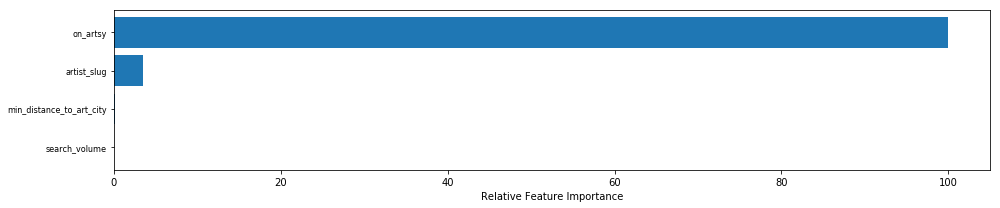

In [113]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### Decision Tree Regression Exploration

In [114]:
from sklearn.tree import DecisionTreeClassifier

# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', DecisionTreeClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: dec_scaled
dec_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a Decision Tree classifier to the unscaled data
dec_unscaled = DecisionTreeClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(dec_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(dec_unscaled.score(X_test, y_test)))


Accuracy with Scaling: 0.7986798679867987
Accuracy without Scaling: 0.8085808580858086


In [115]:
from sklearn.tree import DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


# Setup the hyperparameter grid
param_dist = {"max_depth": [3,5,10,20,50,100],
              "max_features": [1,3,4],
              "min_samples_leaf": [1,3,4],
              "criterion": ["gini", "entropy"],
              "class_weight": ["balanced"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)    

y_pred = tree_cv.predict(X_test)

print(tree_cv.best_params_)
print(tree_cv.best_score_)
print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 4}
0.819858156028
Classification report for classifier                 precision    recall  f1-score   support

 not_qualified       0.53      0.66      0.59        76
very_qualified       0.88      0.81      0.84       227

   avg / total       0.79      0.77      0.78       303
:

Confusion Matrix for classifier [[ 50  26]
 [ 44 183]]:



In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier(class_weight= 'balanced', criterion= 'gini', max_depth= 3, max_features= 7, min_samples_leaf= 3)

# Fit it to the data
tree.fit(X_train, y_train)    

y_pred = tree.predict(X_test)

print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

Classification report for classifier              precision    recall  f1-score   support

          0       0.57      0.43      0.49        65
        100       0.50      0.64      0.56        58

avg / total       0.54      0.53      0.52       123
:

Confusion Matrix for classifier [[28 37]
 [21 37]]:



#### Random Forest Classifier

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


# Setup the hyperparameter grid
param_dist = {"n_estimators": [1,5,10,100,200],
              "max_features": ['auto', 'sqrt', 'log2'],
              "max_depth": [1,5,10,50,100],
              "n_jobs": [-1,1,5,10],
              "class_weight": ["balanced"] }

# Instantiate a Random Forest classifier: tree
forest = RandomForestClassifier(class_weight='balanced')

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = GridSearchCV(forest, param_dist, cv=5)

# Fit it to the data
forest_cv.fit(X_train, y_train)

y_pred = forest_cv.predict(X_test)

print(forest_cv.best_params_)
print(forest_cv.best_score_)

print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1}
0.85390070922
Classification report for classifier                 precision    recall  f1-score   support

 not_qualified       0.59      0.71      0.65        76
very_qualified       0.90      0.84      0.87       227

   avg / total       0.82      0.81      0.81       303
:

Confusion Matrix for classifier [[ 54  22]
 [ 37 190]]:



In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

forest = RandomForestClassifier(class_weight='balanced', max_depth= 5, max_features= 'auto', n_estimators= 200, n_jobs= 1)

# Fit it to the data
forest.fit(X_train, y_train)

#can change to predict_proba to get the probabilities
y_pred = forest.predict(X_test)

print("Non CV Forest")
print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

Non CV Forest
Classification report for classifier              precision    recall  f1-score   support

          0       0.57      0.43      0.49        65
        100       0.50      0.64      0.56        58

avg / total       0.54      0.53      0.52       123
:

Confusion Matrix for classifier [[28 37]
 [21 37]]:



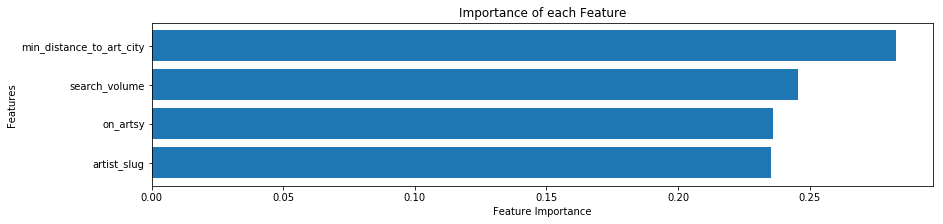

In [117]:
forest.fit(X,y)

imp = forest.feature_importances_
names = X.columns

imp, names = zip(*sorted(zip(imp,names)))

plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Importance of each Feature')
plt.show()

In [ ]:
#http://bigdata-madesimple.com/dealing-with-unbalanced-class-svm-random-forest-and-decision-tree-in-python/

#### Undersample

In [ ]:
df_open_with_many_text_not_on_artsy_undersample = pd.concat([df_open_with_many_text_not_on_artsy[df_open_with_many_text_not_on_artsy.gallery_tier == 0],
                                                             df_open_with_many_text_not_on_artsy[df_open_with_many_text_not_on_artsy.gallery_tier == 100].head(204)])

df_open_with_many_features_undersample = pd.concat([df_open_with_many_features[df_open_with_many_features.gallery_tier == 0], 
                                                    df_open_with_many_features[df_open_with_many_features.gallery_tier == 100].head(240)])df_open_with_many_text_not_on_artsy_undersample = pd.concat([df_open_with_many_text_not_on_artsy[df_open_with_many_text_not_on_artsy.gallery_tier == 0],
                                                             df_open_with_many_text_not_on_artsy[df_open_with_many_text_not_on_artsy.gallery_tier == 100].head(204)])

df_open_with_many_features_undersample = pd.concat([df_open_with_many_features[df_open_with_many_features.gallery_tier == 0], 
                                                    df_open_with_many_features[df_open_with_many_features.gallery_tier == 100].head(240)])

### Notes

Features: Artists on Artsy, Artists Inquiries, Artists Bids, Fairs Participated In, Location, Google Search Score for Artist Name 
Optional: Structured data from website scrape (looking for keywords such Fair, Artists, Exhibitions, Current Exhibition, Past Exhibitions, Represented, Works Available, Services (negative), Submissions (negative) ) 

Take a list of orgs in bearden that have been tiered and have scraped artists. Score those galleries both computationally and by hand, and compare.

Another potential todo: Score a group of artsy partners, observe the distribution of scores-- giving a us a cutoff.

Final step, score the whole list of scraped artist galleries in bearden and see how much of distribution falls above cutoff giving a sense of TAM.

Heuristic models, combine linearly, set coefficients. once have heuristic model can compare to other models
eg. inquiries more important than fairs by 5x
still need pos and neg

will have to deal with biased positives
could normalize by amount of time been on the platform

pos = sub with artist roster
neg = tier 5 with artist roster


Features: Artists on Artsy, Artists Inquiries, Artists Bids, Fairs Participated In, Location, Google Search Score for Artist Name 
Optional: Structured data from website scrape (looking for keywords such Fair, Artists, Exhibitions, Current Exhibition, Past Exhibitions, Represented, Works Available, Services (negative), Submissions (negative) ) 

Other information from website beyond keywords: don't even know 

---------

artists_table = on_artsy, artist_inquries_count, artist_bid_count, google_search_score  
org_table = website, bearden_id, partner_id, location  
org_fairs = website, fair_name, fair_tier  

---------

Take a list of orgs in bearden that have been tiered and have scraped artists. Score those galleries both computationally and by hand, and compare.

Another potential todo: Score a group of artsy partners, observe the distribution of scores-- giving a us a cutoff.

Final step, score the whole list of scraped artist galleries in bearden and see how much of distribution falls above cutoff giving a sense of TAM.

---------

Could be interesting to look at galleries that we have only tier but not artist roster.

---------

if you have thousands of human scored galleries
you might want to see how many of those have, say, three or more of the features you're looking to use.

if you have a few hundred or more you could do a logistic regression on those scores
like that you don't have to worry about classes, positives or negatives, as long as you have a good range of scores in there.

that regression will give you a basic sense of the importance of each of those features in determining the score
as you can reason about the model by just looking at the coefficients it outputs for each feature

it would be good to try and leverage those scores if we have some faith in their consistency



**notes from meeting 11/30**

- *Decision Tree to small, Change to RandomForest Classifier*
- Normalize for how long artist has been on the platform maybe?
- *pass in class weights for logreg*
- *translate tier into #'s*
- *redundency between Impressions and Search Volume, remove one*
- include target in correlation and scatter matrix (new type of matrix)
    - Pair wise plots
- *Use either region or distance from art center *
- Look into how well artist slug match works, otherwise use Artsy Artist Name Match API
- Too much class imbalance
    - ie only predicting certain tiers
    - class weights might help
        - not all tiers are equal

 